# Activation Heatmaps with keras model


In This notebook, I will show you how to add an activation heatmap to a tf.keras image classification model.
<strong>What is an Activation heatmap?</strong>
An activation map is a simple technique to get the discriminative image regions used by a CNN to identify a specific class in the image. This means the most important parts of an image that are used in classifying the image.

In this tutorial, we are going to need openCv. To download openCv visit [OpencV-Python](https://pypi.org/project/opencv-python/) website or if you want to install it with conda, open your terminal in administrator mode and type in <code>conda install -c menpo opencv</code> and press enter. <p></p>
If you have done that already then lets proceed 

<h2>First, we will import all the needed libaries for this tutorail</h2>

In [3]:
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras import backend as Kbe
from keras.applications.vgg16 import VGG16

In [4]:
#Using the VGG16 model 
model = VGG16(weights = 'imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



<h3>The image below is the what we will be using to put activation heatmaps on and at the end of this tutorial, you will be able to create your own activation maps on images from any where</h3>

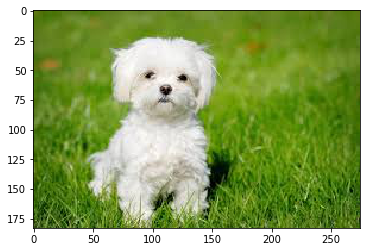

In [5]:
img_path = 'img/dog_img.jpg'
img = mpimg.imread(img_path)
plt.imshow(img)

<h3>Next: we wil resize the image and convert it to a numpy array</h3>

In [6]:
from keras.preprocessing import image

img = image.load_img(img_path, target_size=(224, 224))
np_array = image.img_to_array(img)


<h3>Now we will reshape the numpy array so that it should be in batch form because the this is how our model accepts input</h3>

In [7]:
np_array = np.expand_dims(np_array, axis=0)
print(np_array.shape)

(1, 224, 224, 3)


<h3>We will process the batch form now</h3>

In [8]:
np_array = preprocess_input(np_array)
print(np_array)

[[[[ -80.939         6.2210007   -22.68      ]
   [ -81.939         5.2210007   -23.68      ]
   [ -86.939         1.2210007   -30.68      ]
   ...
   [ -90.939         6.2210007   -36.68      ]
   [ -87.939         1.2210007   -33.68      ]
   [ -87.939         1.2210007   -33.68      ]]

  [[ -81.939         5.2210007   -23.68      ]
   [ -82.939         4.2210007   -24.68      ]
   [ -86.939         1.2210007   -30.68      ]
   ...
   [ -88.939         6.2210007   -36.68      ]
   [ -86.939         2.2210007   -32.68      ]
   [ -87.939         1.2210007   -33.68      ]]

  [[ -83.939         4.2210007   -27.68      ]
   [ -83.939         4.2210007   -27.68      ]
   [ -87.939         0.22100067  -32.68      ]
   ...
   [ -88.939         6.2210007   -36.68      ]
   [ -86.939         2.2210007   -32.68      ]
   [ -86.939         2.2210007   -32.68      ]]

  ...

  [[  23.060997     79.221        45.32      ]
   [ -58.939003     -4.7789993   -38.68      ]
   [ -67.939       -19.779

<h3>Now we will do predictions on the image and its category</h3>

In [9]:
predict = model.predict(np_array)
predictions = pd.DataFrame(decode_predictions(predict, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
print('PREDICTION:',predictions.loc[0,'category'])


PREDICTION: Maltese_dog


Text(0.5, 1.0, 'Top 3 Predictions:')

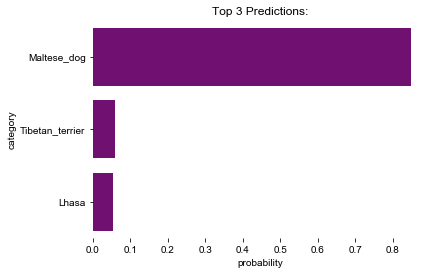

In [10]:
f = sns.barplot(x='probability',y='category',data=predictions,color="purple")
sns.set_style(style='white')
f.grid(False)
f.spines["top"].set_visible(False)
f.spines["right"].set_visible(False)
f.spines["bottom"].set_visible(False)
f.spines["left"].set_visible(False)
f.set_title('Top 3 Predictions:')

In [12]:
argmax = np.argmax(predict[0])

output = model.output[:, argmax]


In [13]:
#getting last convolutional layer
conv_layer = model.get_layer('block5_conv3')

#getting the gradient
grads = Kbe.gradients(output, conv_layer.output)[0]

pooled_grads = Kbe.mean(grads, axis=(0, 1, 2))

<h3>Access the values of the quantities we just defined above</h3>

In [14]:
iterate = Kbe.function([model.input], [pooled_grads, conv_layer.output[0]])

#These are the values of these two quantities, as Numpy arrays, given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([np_array])

In [15]:
#We multiply each channel in the feature map array by how important this channel is
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

<h3>Now we will plot the heatmap</h3>

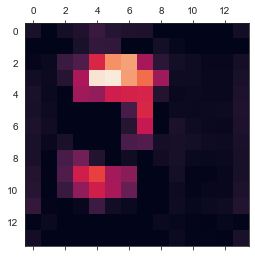

In [16]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

<h3>Below, we will</h3>
<ol>
    <li>Load Image with CV2  </li>
    <li>Resize the heatmap  </li>
    <li>Convert heatmap to RGB  </li>
    <li>Apply heatmap to original Image  </li>
    <li>Apply heatmap intensity factor  </li>
    <li>Save the image</li>
</ol>


In [31]:
 #Load Image with CV2
img = cv2.imread(img_path)

#Resize the heatmap
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

#Convert heatmap to RGB
heatmap = np.uint8(255 * heatmap)

#Apply heatmap to original Image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

#Apply heatmap intensity factor
hmap_intens_fac = 0.89
superimposed_img = heatmap * hmap_intens_fac + img

#Save the image
output = 'img/dog_output.jpeg'
cv2.imwrite(output, superimposed_img)

#read the output image
img=mpimg.imread(output)

<h3>Finaly we Plot the output with the heatmap </h3>

Text(0.5, 1.0, 'Maltese_dog')

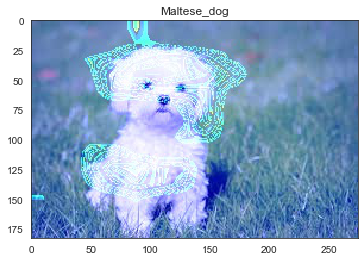

In [32]:
plt.imshow(img)
plt.title(predictions.loc[0,'category'])

<h3>This is where our tutorial ends you can go ahead and try it wiht other images of your choice</h3>